ASOS 데이터는 아래와 같은 순서로 완성되었습니다.

1. <a href = 'https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1'>기상청 기상자료 개방포털</a> ASOS 데이터크롤링 (Selenium, Python)
2. 다운로드 받은 압축파일 압축풀기 (수기)
3. 합치고자 하는 csv 파일을 선택하여 합치기 및 5분 간격 데이터 분리 (Pandas, Python)
4. 관측소 ID별로 행이 존재하지 않는 시간대를 Null값 행으로 채워넣기 및 저장(Pandas, Python)

1. <a href = 'https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1'>기상청 기상자료 개방포털</a> ASOS 데이터크롤링 (Selenium, Python)

In [ ]:
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time

# 사이트 접속
service = Service('./driver/chromedriver.exe')
driver = webdriver.Chrome(service = service)
driver.get('https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1')

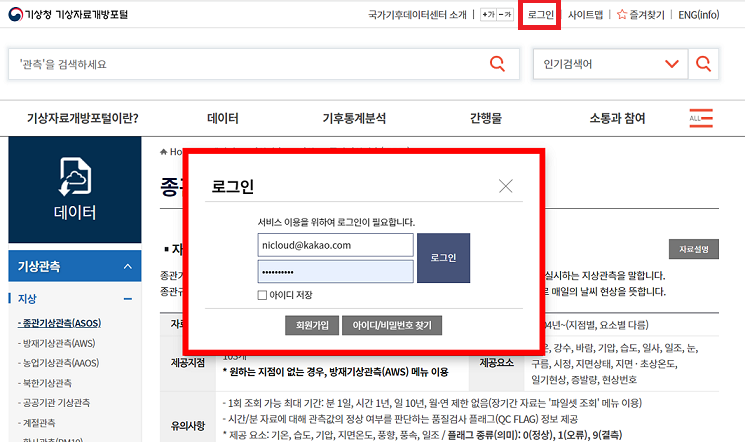

In [ ]:
time.sleep(3)
driver.find_element(By.XPATH, '/html/body/div[2]/header/div[2]/div/div/ul[2]/li[2]/a').click() # 상단 로그인 버튼 클릭
driver.find_element(By.XPATH, '//*[@id="loginId"]').send_keys('your id') # 아이디(이메일) 입력
driver.find_element(By.XPATH, '//*[@id="passwordNo"]').send_keys('your password') # 비밀번호 입력
driver.find_element(By.XPATH, '/html/body/div[3]/div/div/div[2]/form/div[1]/div/button').click() # 로그인 확인 버튼 클릭

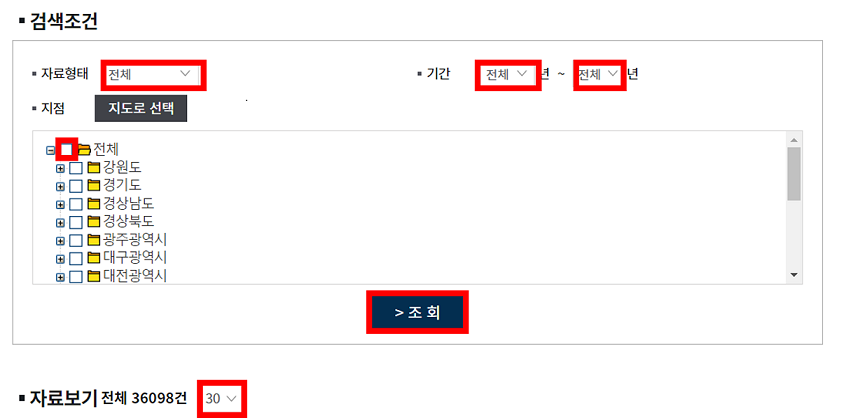

In [ ]:
start_year = '2020'
end_year = '2023'
data_type = '분 자료'

driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[2]/dd/select[1]').send_keys(start_year) # 시작연도
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[2]/dd/select[3]').send_keys(end_year) # 마지막연도
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[4]/div[1]/select').send_keys('50') # 1개의 화면에 노출될 파일의 갯수 : 50개
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[1]/dd/select').send_keys(data_type) # 자료형태 선택
time.sleep(1)
driver.find_element(By.XPATH, '//*[@id="ztree_1_check"]').click() # '전체' 데이터 선택
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[3]/button').click() # 조회 버튼 클릭

In [ ]:
# 페이지의 개수 계산하기
# (1개의 화면에 노출될 파일의 갯수와 전체 자료의 갯수를 활용하여 페이지의 개수를 계산합니다)

num_of_data = int(driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[1]/span/strong').text.split(' ')[1][:-1])
if num_of_data % 50 == 0:
    page_length = num_of_data // 50
else:
    page_length = num_of_data // 50 + 1

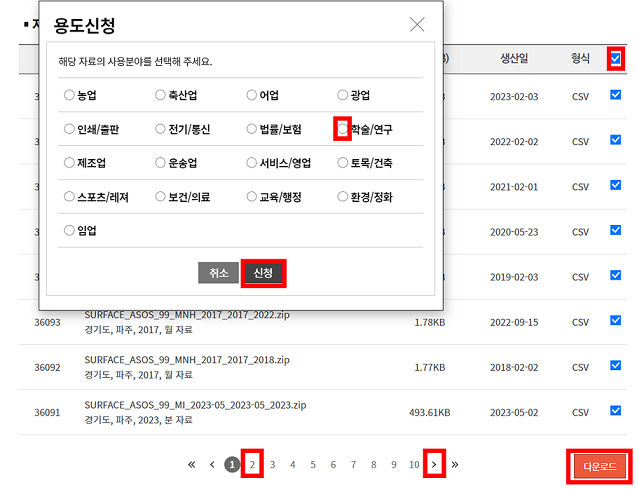

In [ ]:
# 페이지별 압축파일 다운로드 하기

from tqdm import tqdm

for page_num in tqdm(range(1, page_length + 1)):
    if page_num % 10 == 0:
        driver.find_element(By.XPATH, '//*[@id="checkAll"]').click() # 전체 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[2]/a').click() # 다운로드 버튼 클릭
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="reqstPurposeCd7"]').click() # 다운로드 목적 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap-datapop"]/div/div[2]/div/a[2]').click() # 신청 클릭
        time.sleep(1)
        if page_num != page_length:
            driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[1]/ul/li[13]/a').click() # 다음 페이지 클릭
            time.sleep(15)
        else:
            break
    else:
        driver.find_element(By.XPATH, '//*[@id="checkAll"]').click() # 전체 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[2]/a').click() # 다운로드 버튼 클릭
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="reqstPurposeCd7"]').click() # 다운로드 목적 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap-datapop"]/div/div[2]/div/a[2]').click() # 신청 클릭
        time.sleep(1)
        if page_num != page_length:
            XPATH = '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[1]/ul/li['+ str(page_num % 10 + 3) +']/a'
            driver.find_element(By.XPATH, XPATH).click() # 다음 페이지 클릭
            time.sleep(15)
        else:
            break

2. 다운로드 받은 압축 파일 풀기

페이지별 압축 파일 안에는 최대 50개의 csv 압축파일이 포함되어 있고, csv 압축파일 안에는 1개의 csv 파일이 포함되어 있습니다. <br>
이후 진행되는 데이터 결합을 진행하기 위해서는 압축을 모두 풀어주어야 합니다. (이 부분은 수기로 진행하였습니다.)

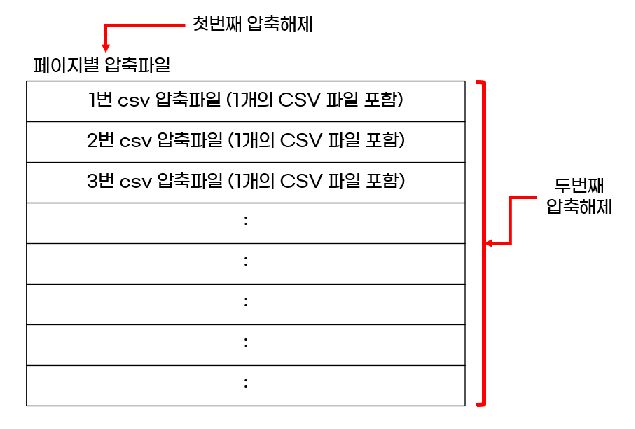

3. 합치고자 하는 csv 파일을 선택하여 합치기 및 5분 간격 데이터 분리

<a href = 'https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1'>기상청 기상자료 개방포털</a>의 ASOS 1분 간격 데이터는 월별 데이터도 있지만 연도별 데이터도 있습니다.<br> 
단, 연도별 데이터는 해당 연도 이후에 다운로드 받을 수 있으므로 올해의 데이터를 이용해야 한다면 월별 데이터를 합쳐야 합니다.<br>
2번까지의 과정으로 내려받은 csv 파일 중 파일명에 아래의 키워드를 포함하는 파일만 선택하여 합칩니다.

※ 1번의 과정에서 합칠 데이터만 선택하여 내려받는 것이 합리적인 방법이나, <br>
현재 저의 스킬로는 구현이 어렵다고 판단되어 모든 데이터를 내려받은 뒤 필요한 것을 선택하여 합치는 방법을 택하였습니다.

|키워드|키워드 내용|
|--|--|
|'2020_2020'|관측소별 2020년 연도 데이터|
|'2021-01_2021-12'|관측소별 2021년 연도 데이터|
|'2022-01_2022-12'|관측소별 2022년 연도 데이터|
|'2023-01_2023-01'|관측소별 2023년 1월 데이터|
|'2023-02_2023-02'|관측소별 2023년 2월 데이터|
|'2023-03_2023-03'|관측소별 2023년 3월 데이터|
|'2023-04_2023-04'|관측소별 2023년 4월 데이터|
|'2023-05_2023-05'|관측소별 2023년 5월 데이터|

In [ ]:
# 합칠 데이터 리스트 가져오기 및 개수 확인 
# 2020년부터 2023년까지의 데이터를 합치려고 할 때 파일의 개수
# 관측소의 개수 97개 * 8개의 파일 = 776개

import os
files = os.listdir('your path')

def target(x):
    keywords = ['2020_2020',
                '2021-01_2021-12',
                '2022-01_2022-12',
                '2023-01_2023-01',
                '2023-02_2023-02',
                '2023-03_2023-03',
                '2023-04_2023-04',
                '2023-05_2023-05']
    
    return any(keyword in x for keyword in keywords)

files = list(filter(target, files))
len(files) # 776

In [ ]:
# 하나의 데이터 프레임으로 합치기

from tqdm import tqdm
import pandas as pd

base_path = '' # 기본 경로 설정

for idx, file in enumerate(tqdm(files)):
  if idx == 0:
    df_all = pd.read_csv(base_path + file, encoding = 'euc-kr')
  else:
    df =  pd.read_csv(base_path + file, encoding = 'euc-kr')
    df_all = pd.concat([df_all, df])

# 지점과 일시로 정렬하기

df_all = df_all.sort_values(['지점', '일시'])

# 최초의 결합파일 parquet 파일로 저장 (1분, 간격, 5분 간격)

df_all.to_parquet('your path')
df_all[pd.to_datetime(df_all['일시']).dt.minute % 5 == 0].to_parquet('your path')

4. 관측소 ID별로 행이 존재하지 않는 시간대를 Null값 행으로 채워넣기 및 저장(Pandas, Python)

<a href = 'https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1'>기상청 기상자료 개방포털</a>에서 내려받은 자료는 행이 존재하지 않는 시간대가 있습니다.<br>
예를 든다면 다음과 같습니다. (15:02와 15:05를 나타내는 행이 없음)

|지점|일시|기상데이터 1|
|--|--|--|
|서울 |2023-01-01 15:00|5|
|서울 |2023-01-01 15:01|6|
|서울 |2023-01-01 15:03|5|
|서울 |2023-01-01 15:04|7|
|서울 |2023-01-01 15:06|8|
|서울 |2023-01-01 15:07|9|

그렇기 때문에 모든 관측소의 기상데이터의 개수가 동일할 수 있도록 맞춰주는 작업이 필요하며,<br>
이 작업이 완료된 기상 데이터가 저희가 사용한 ASOS 데이터 입니다.

In [ ]:
import pandas as pd
from tqdm import tqdm

# 1분 간격 ASOS 데이터 불러오기
weather_1minute_ASOS = pd.read_parquet('your path')


# 1분 간격 데이터 중 없어진 시간대를 Null값으로 넣기
STN_list = list(weather_1minute_ASOS['지점'].unique())

for idx, STN in enumerate(tqdm(STN_list)):
  tmp = pd.DataFrame()
  date_list = list(pd.date_range('2020-01-01 00:01', '2023-05-20 00:59', freq = '1min'))
  tmp['일시'] = [str(date)[:-3] for date in date_list]
  tmp = pd.merge(tmp, weather_1minute_ASOS[weather_1minute_ASOS['지점']==STN], on = '일시', how = 'left')
  tmp['지점'] = tmp['지점'].fillna(STN)

  if idx == 0:
    weather_1minute_ASOS_refined = tmp
  else:
    weather_1minute_ASOS_refined = pd.concat([weather_1minute_ASOS_refined, tmp])

right_columns = ['지점',
                 '일시',
                 '기온(°C)',
                 '누적강수량(mm)',
                 '풍향(deg)',
                 '풍속(m/s)',
                 '현지기압(hPa)',
                 '해면기압(hPa)',
                 '습도(%)',
                 '일사(MJ/m^2)',
                 '일조(Sec)']

weather_1minute_ASOS_refined = weather_1minute_ASOS_refined[right_columns]
weather_1minute_ASOS_refined.to_parquet('your path')

In [ ]:
# 5분 간격 데이터 중 없어진 시간대를 Null값으로 넣기

import pandas as pd
weather_5minute_ASOS = pd.read_parquet('your path')

from tqdm import tqdm

STN_list = list(weather_5minute_ASOS['지점'].unique())

for idx, STN in enumerate(tqdm(STN_list)):
  tmp = pd.DataFrame()
  date_list = list(pd.date_range('2020-01-01 00:05', '2023-05-20 00:55', freq = '5min'))
  tmp['일시'] = [str(date)[:-3] for date in date_list]
  tmp = pd.merge(tmp, weather_5minute_ASOS[weather_5minute_ASOS['지점']==STN], on = '일시', how = 'left')
  tmp['지점'] = tmp['지점'].fillna(STN)
  tmp
  if idx == 0:
    weather_5minute_ASOS_refined = tmp
  else:
    weather_5minute_ASOS_refined = pd.concat([weather_5minute_ASOS_refined, tmp])

right_columns = ['지점',
                 '일시',
                 '기온(°C)',
                 '누적강수량(mm)',
                 '풍향(deg)',
                 '풍속(m/s)',
                 '현지기압(hPa)',
                 '해면기압(hPa)',
                 '습도(%)',
                 '일사(MJ/m^2)',
                 '일조(Sec)']

weather_5minute_ASOS_refined = weather_5minute_ASOS_refined[right_columns]
weather_5minute_ASOS_refined.to_parquet('your path')